# LMUL Speed Comparisons

Comparing performance of:
1. Standard Python multiplication
2. Standard NumPy multiplication
3. Standard PyTorch multiplication
4. NumPy vectorized LMUL
5. PyTorch vectorized LMUL
6. Verilog pipeline (hardware simulation)
7. Verilog pipeline parallelized (4 DUTs)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

os.chdir(Path.cwd().parent)

from rtl.numpy_lmul import lmul_numpy_vectorized
from rtl.lmul_tester import BatchLMULTester, BatchLMULTesterParallel
from utils.floats import (
    float_to_bf16,
    bf16_to_float,
    float_to_bf16_array,
    bf16_to_float_array
)

try:
    import torch
    from rtl.pytorch_lmul import lmul_torch_vectorized
    from utils.floats import float_to_bf16_tensor, bf16_to_float_tensor
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False

batch_tester = BatchLMULTester()
parallel_tester = BatchLMULTesterParallel()
SIMULATION_CLOCK_HZ = 100_000_000


In [2]:
test_sizes = np.array([10 ** i for i in range(1, 6)])

py_times = []
np_times = []
pytorch_standard_times = []
numpy_lmul_times = []
pytorch_lmul_times = []
verilog_times = []
verilog_theoretical_times = []
verilog_parallel_times = []


In [3]:
for size in test_sizes:
    np.random.seed(42)
    a_floats = np.random.uniform(-10, 10, size).astype(np.float32)
    b_floats = np.random.uniform(-10, 10, size).astype(np.float32)
    
    a_bf16 = np.array([float_to_bf16(f) for f in a_floats], dtype=np.uint16)
    b_bf16 = np.array([float_to_bf16(f) for f in b_floats], dtype=np.uint16)
    test_pairs = [(a, b) for a, b in zip(a_bf16, b_bf16)]
    
    start = time.time()
    py_results = [a * b for a, b in zip(a_floats, b_floats)]
    py_times.append(time.time() - start)
    
    start = time.time()
    np_results = a_floats * b_floats
    np_times.append(time.time() - start)
    
    if TORCH_AVAILABLE:
        a_torch = torch.from_numpy(a_floats)
        b_torch = torch.from_numpy(b_floats)
        _ = a_torch * b_torch
        start = time.time()
        pytorch_standard_results = a_torch * b_torch
        torch.synchronize() if torch.cuda.is_available() else None
        pytorch_standard_times.append(time.time() - start)
    else:
        pytorch_standard_times.append(None)
    
    a_bf16_vec = float_to_bf16_array(a_floats)
    b_bf16_vec = float_to_bf16_array(b_floats)
    start = time.time()
    numpy_lmul_results = lmul_numpy_vectorized(a_bf16_vec, b_bf16_vec)
    numpy_lmul_times.append(time.time() - start)
    
    if TORCH_AVAILABLE:
        a_torch_bf16 = float_to_bf16_tensor(torch.from_numpy(a_floats))
        b_torch_bf16 = float_to_bf16_tensor(torch.from_numpy(b_floats))
        _ = lmul_torch_vectorized(a_torch_bf16, b_torch_bf16)
        start = time.time()
        pytorch_lmul_results = lmul_torch_vectorized(a_torch_bf16, b_torch_bf16)
        torch.synchronize() if torch.cuda.is_available() else None
        pytorch_lmul_times.append(time.time() - start)
    else:
        pytorch_lmul_times.append(None)
    
    hw_results, hw_time, cycles_window, _ = batch_tester.test_batch(test_pairs)
    verilog_times.append(hw_time)
    hw_total_latency = cycles_window / SIMULATION_CLOCK_HZ
    verilog_theoretical_times.append(hw_total_latency)
    
    try:
        hw_parallel_results, hw_parallel_time = parallel_tester.test_batch(test_pairs, verbose=False)
        verilog_parallel_times.append(hw_parallel_time)
        if len(hw_parallel_results) > size:
            hw_parallel_results = hw_parallel_results[:size]
    except:
        verilog_parallel_times.append(None)


In [4]:
py_op_times = np.array(py_times) / test_sizes
np_op_times = np.array(np_times) / test_sizes
if TORCH_AVAILABLE:
    pytorch_standard_op_times = np.array([t if t is not None else np.nan for t in pytorch_standard_times]) / test_sizes
else:
    pytorch_standard_op_times = None
numpy_lmul_op_times = np.array(numpy_lmul_times) / test_sizes
if TORCH_AVAILABLE:
    pytorch_lmul_op_times = np.array([t if t is not None else np.nan for t in pytorch_lmul_times]) / test_sizes
else:
    pytorch_lmul_op_times = None
verilog_op_times = np.array(verilog_times) / test_sizes
verilog_theoretical_op_times = np.array(verilog_theoretical_times) / test_sizes
verilog_parallel_op_times = np.array([t if t is not None else np.nan for t in verilog_parallel_times]) / test_sizes


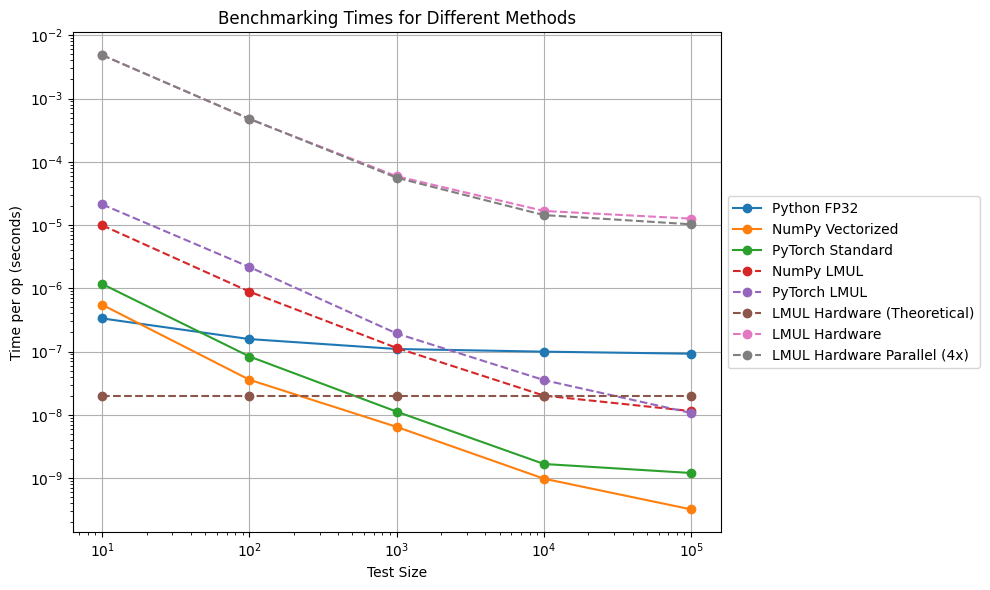

In [5]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

plt.plot(test_sizes, py_op_times, label='Python FP32', marker='o')
plt.plot(test_sizes, np_op_times, label='NumPy Vectorized', marker='o')
if TORCH_AVAILABLE:
    plt.plot(test_sizes, pytorch_standard_op_times, label='PyTorch Standard', marker='o')
plt.plot(test_sizes, numpy_lmul_op_times, label='NumPy LMUL', marker='o', linestyle='--')
if TORCH_AVAILABLE:
    plt.plot(test_sizes, pytorch_lmul_op_times, label='PyTorch LMUL', marker='o', linestyle='--')
plt.plot(test_sizes, verilog_theoretical_op_times, label='LMUL Hardware (Theoretical)', marker='o', linestyle='--')
plt.plot(test_sizes, verilog_op_times, label='LMUL Hardware', marker='o', linestyle='--')
if np.any(~np.isnan(verilog_parallel_op_times)):
    plt.plot(test_sizes, verilog_parallel_op_times, label='LMUL Hardware Parallel (4x)', marker='o', linestyle='--')

plt.xlabel('Test Size')
plt.ylabel('Time per op (seconds)')
plt.title('Benchmarking Times for Different Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
 